# Initial Condition Sensitivity Analysis
Analyze the sensitivity of the filament dynamics to Initial Conditions.

Procedure:
- Start with a simulation after transients are over.
- Choose random points corresponding to different phase and time values. 
- For each point choose O(100) nearby points by adding a random perturbation to the filament shape.
- Simulate the dynamics starting with these IC over a further N cycles.
- For each pair of closely separated IC, calculate the pair-wise Euclidean distance between the filament shapes.
- Plot the change in this pair-wise distance over time and average over all ICs (closely separed). Also average over many different ICs

In [6]:
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
    
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import interpolate
import h5py


import os
from sys import platform

import pyfilaments.analysisutils as analysis
from pyfilaments.activeFilaments import activeFilament

import imp
imp.reload(analysis)
%matplotlib notebook
plt.close('all')

# Figure parameters
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import cm
from tqdm import tqdm

rc('font', family='sans-serif') 
rc('font', serif='Helvetica') 
rc('text', usetex='false') 
rcParams.update({'font.size': 12})

# Check which platform
if platform == "linux" or platform == "linux2":
    print("linux system")
    # root_path = '/home/deepak/Dropbox/LacryModeling/ModellingResults'
    root_path = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults'

elif platform == 'darwin':
    print("OSX system")
    root_path = '/Users/deepak/Dropbox/LacryModeling/ModellingResults'

linux system


## Load a filament simuation where transients have decayed

In [7]:
# Aperiodic
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5256410256410255_activityTime_750_simType_point/SimResults_00.hdf5'

# Period 2
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point/SimResults_00.hdf5'

# Period 2 (higher activity)
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.9743589743589742_activityTime_750_simType_point/SimResults_00.hdf5'

# Period 4
file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/SimResults_00.hdf5'

# Period 6
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5897435897435896_activityTime_750_simType_point/SimResults_01.hdf5'

# Period 10
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.3974358974358974_activityTime_750_simType_point/SimResults_00.hdf5'

# Aperiodic higher activity
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.6794871794871793_activityTime_750_simType_point/SimResults_00.hdf5'

# Constant activity
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ConstantCompressiveActivity_sweep/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point/SimResults_00_.hdf5'

fil = analysis.analysisTools(file = file)

ic_analysis_folder = os.path.join(fil.rootFolder, 'IC_analysis')


3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.999733340444255
No:of particles : 32
No:of time points : 37501
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00.hdf5


<IPython.core.display.Javascript object>


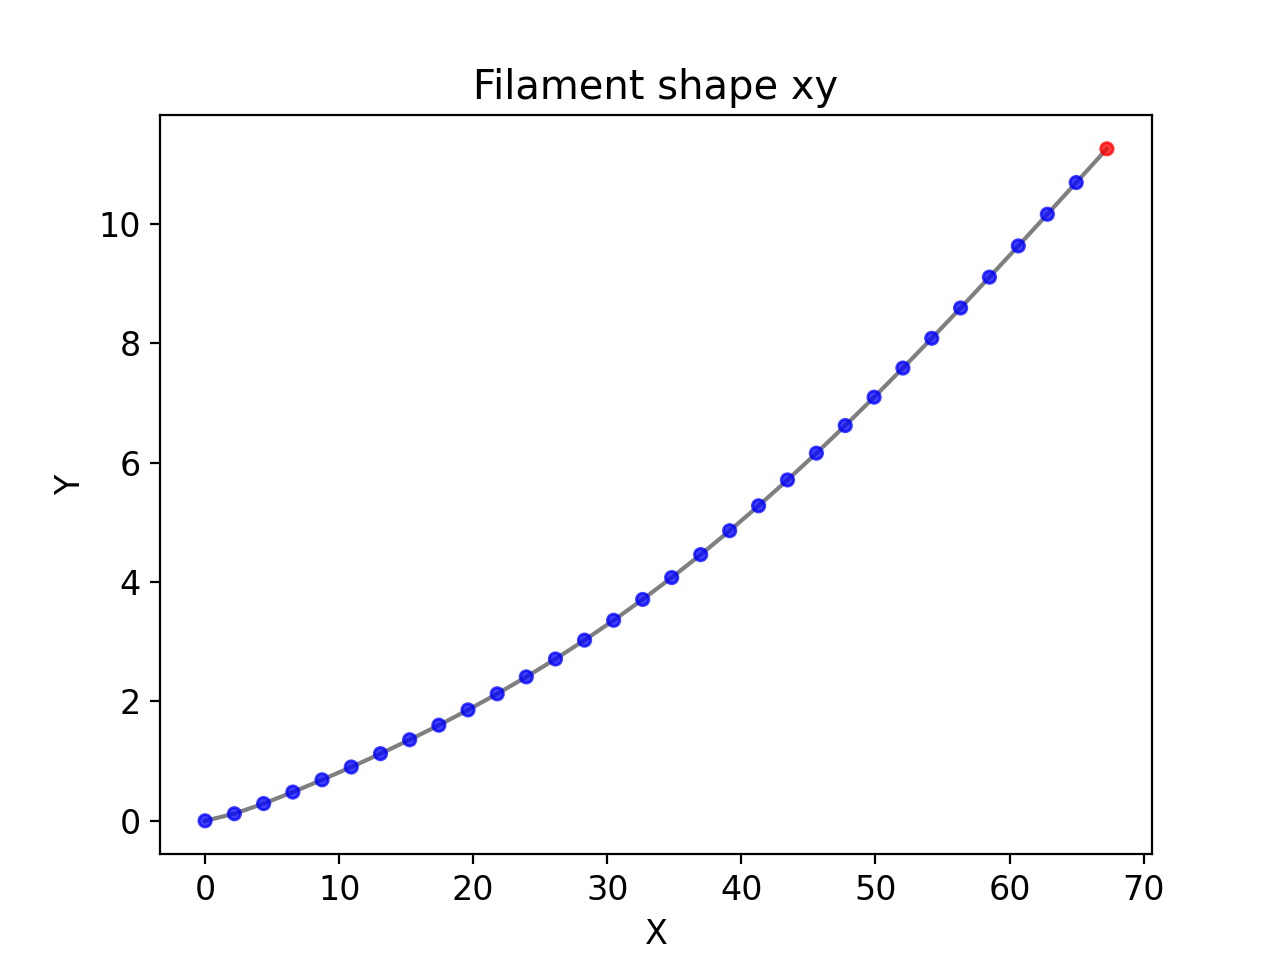

In [4]:
final_shape = fil.R[-1,:]
plt.figure()
fil.plotFilament(r = final_shape)

## Choose ICs after transients have decayed

In [38]:
import random

N_cycles = int(fil.Time[-1]/fil.activity_timescale)
N_transient = 100 # No:of activity cycles for transients to decay. 

N_IC_time = 10 # IC based on different activity cycles/time
N_IC_phase = 1 # Different IC within each activity phase

N_IC_nearby = 10

delta_IC = 1e-12 # Average distance between nearby ICs.

# Choose n random activity cycles (time)
n_cycles = random.sample(range(N_transient, N_cycles), N_IC_time)

print(n_cycles)

# Within each activity cycle choose points evenly distributed in phase
n_phase = random.sample(list(np.linspace(0, 2*np.pi, 100)), N_IC_phase)

print(n_phase)

# Compute the minimum resolved phase difference in the simulations
delta_phase = 2*np.pi*np.mean(fil.Time[1:] - fil.Time[:-1])/fil.activity_timescale # Smallest change in phase

time_points = np.array(range(0, len(fil.Time)))
# Find the index corresponding to each unique IC

# Create empty array to store indices for each unique IC

ic_mesh = np.empty((N_IC_time, N_IC_phase), dtype = int)

# Phase array for the whole simulation
phase_array = 2*np.pi*(fil.Time%fil.activity_timescale)/fil.activity_timescale


for ii, phase in enumerate(n_phase):
    
    print(phase)
    print(fil.derived_data['Phase'])
    abs_val_array = np.abs(fil.derived_data['Phase'] - phase)
    constant_phase_mask = abs_val_array <= 0.5*delta_phase
    
    time_indices = time_points[constant_phase_mask]
   
  
    

    
    ic_mesh[:, ii] = time_indices[n_cycles]
    


    
    
    
    

[451, 440, 235, 182, 264, 442, 133, 217, 345, 120]
[3.0463928762082846]
3.0463928762082846
[0.         0.0837758  0.16755161 ... 6.1156337  6.1994095  0.        ]


In [29]:
print(ic_mesh)

[[17227]
 [10702]
 [ 9577]
 [30652]
 [15277]
 [27577]
 [11452]
 [13327]
 [28402]
 [12727]]


# Generate Filament Initial Conditions and Store them
For each IC generated above, generate N nearby initial conditions and save the resulting filament shapes $\delta$

- Save the generated filament shape ICs to disk (in a sub-folder of the original sim data)
    eg. /SimResults/IC_analysis
- Save each unique IC in a separate folder
    eg./SimResults/IC_analysis/IC_{index}
- Within that folder the results from the

<IPython.core.display.Javascript object>


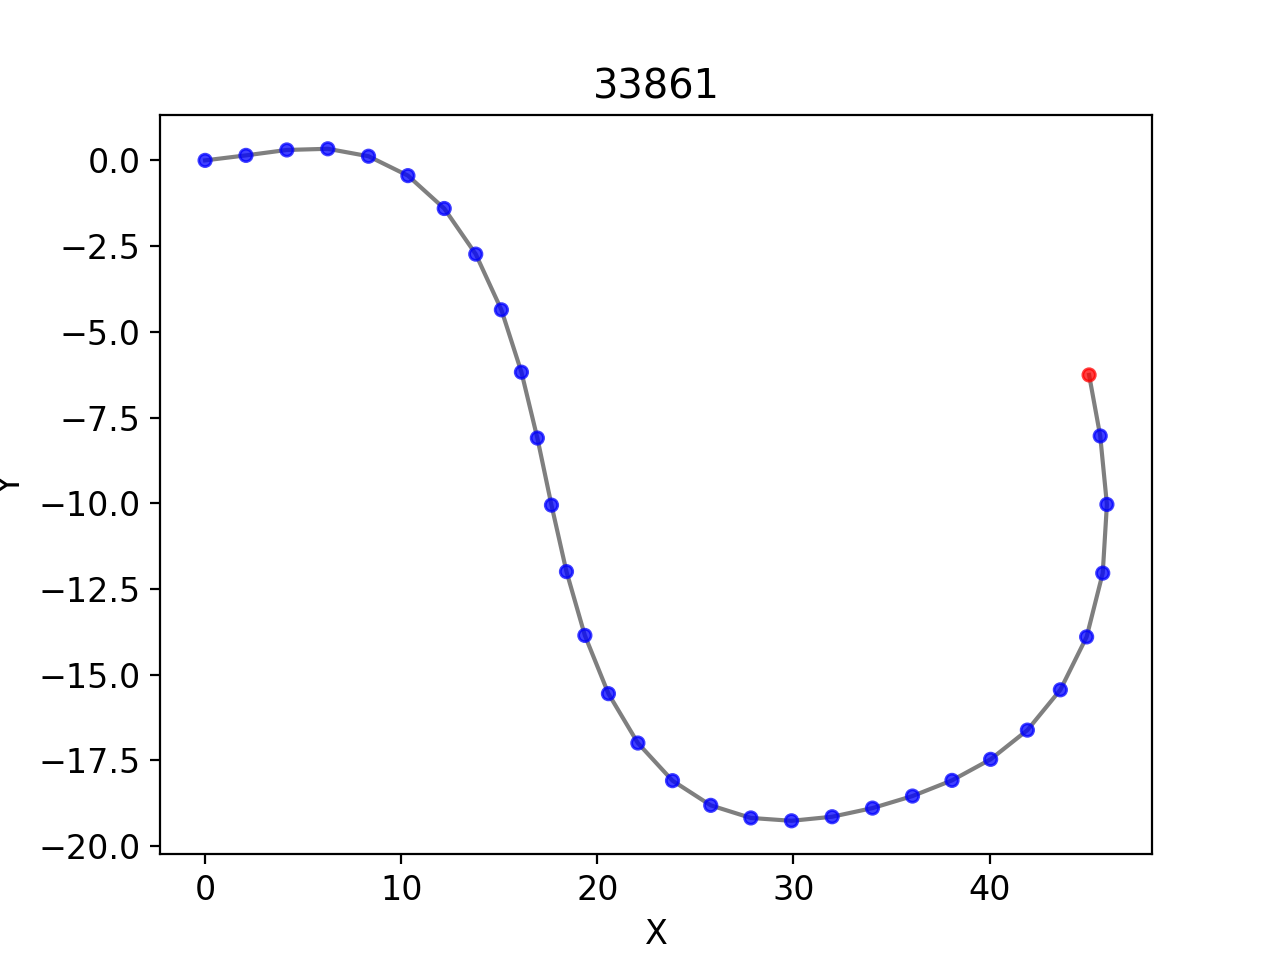

<IPython.core.display.Javascript object>


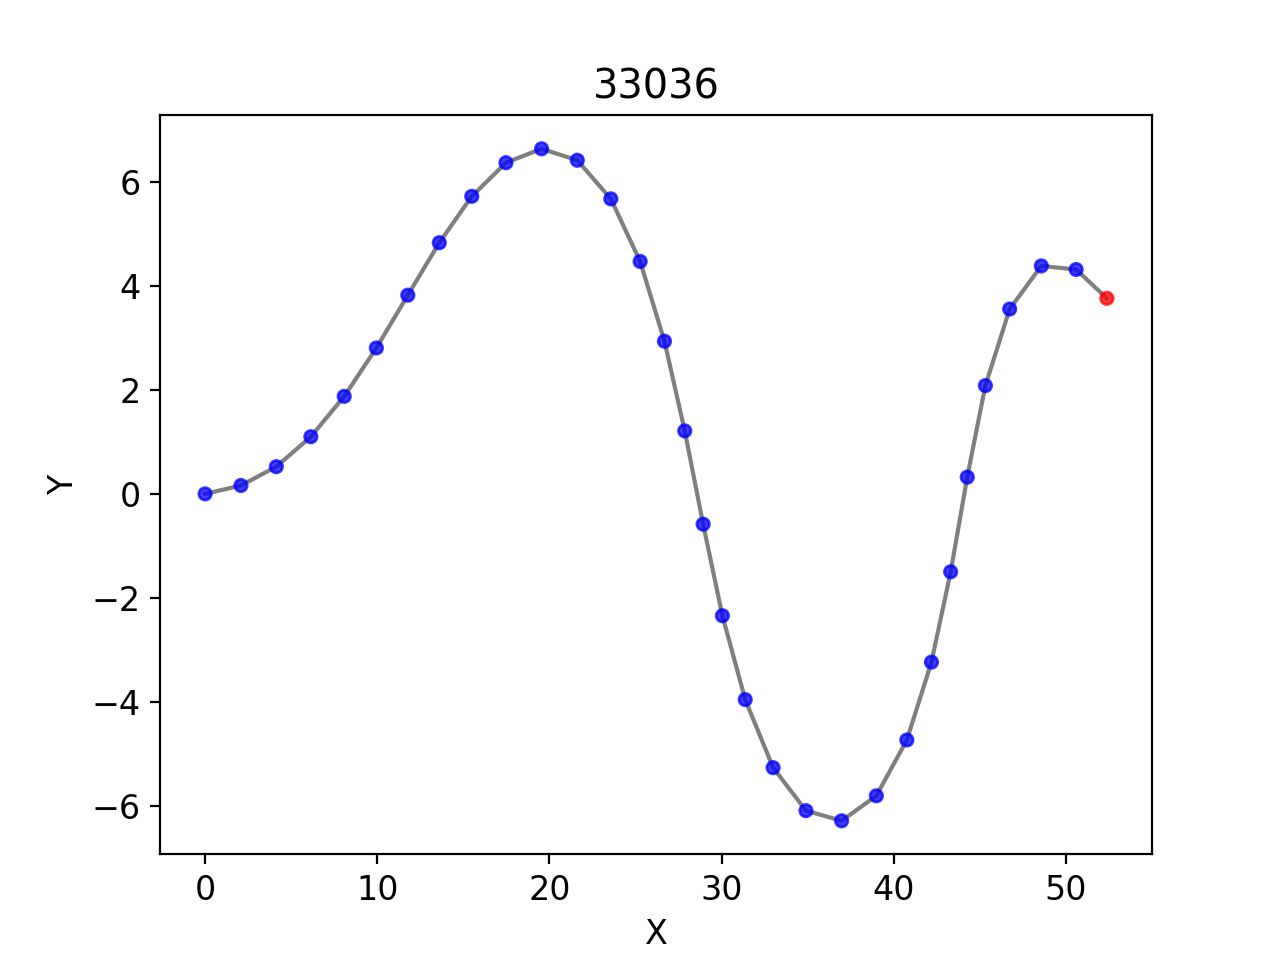

<IPython.core.display.Javascript object>


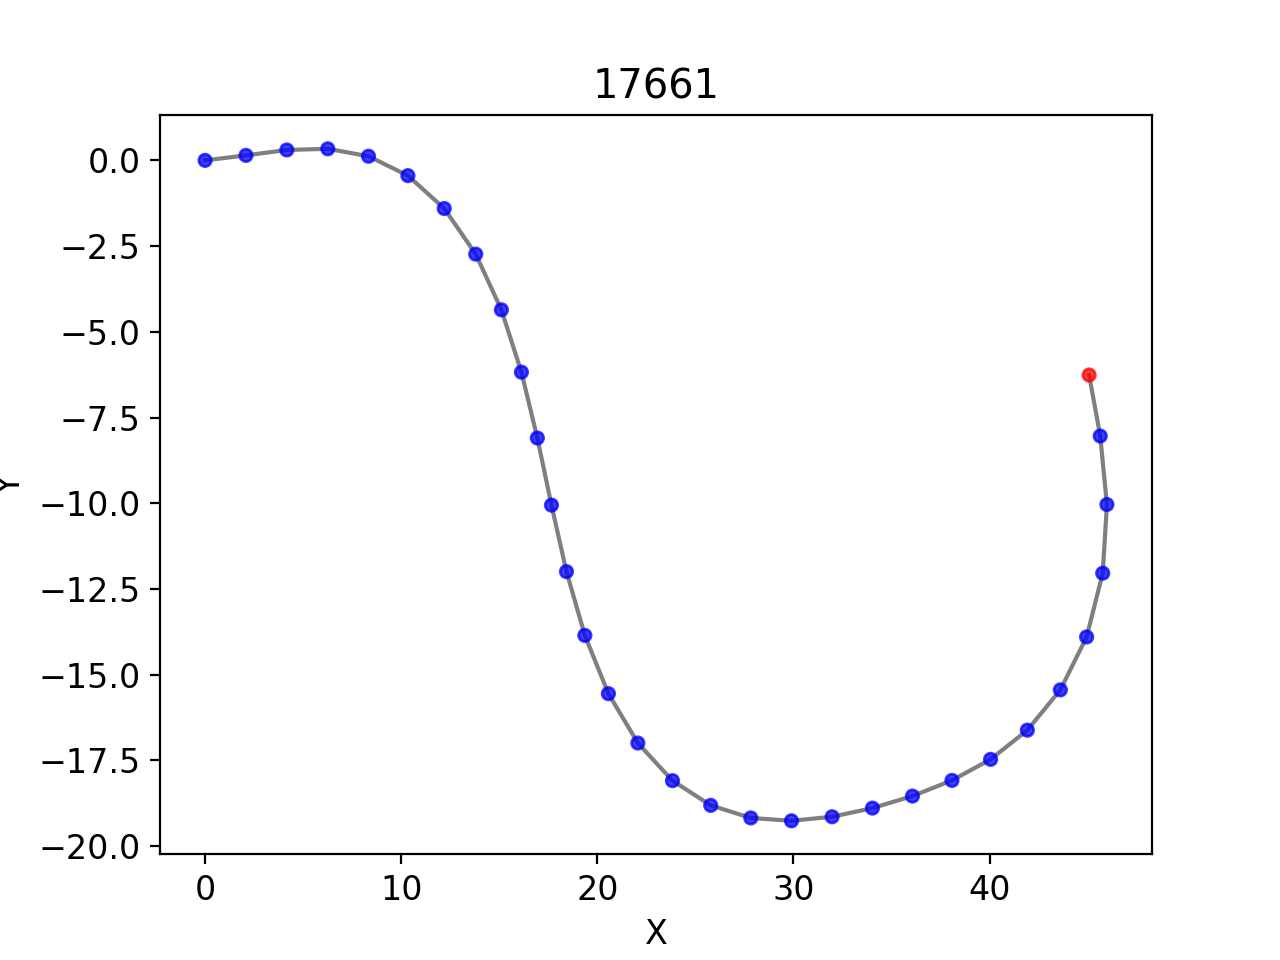

<IPython.core.display.Javascript object>


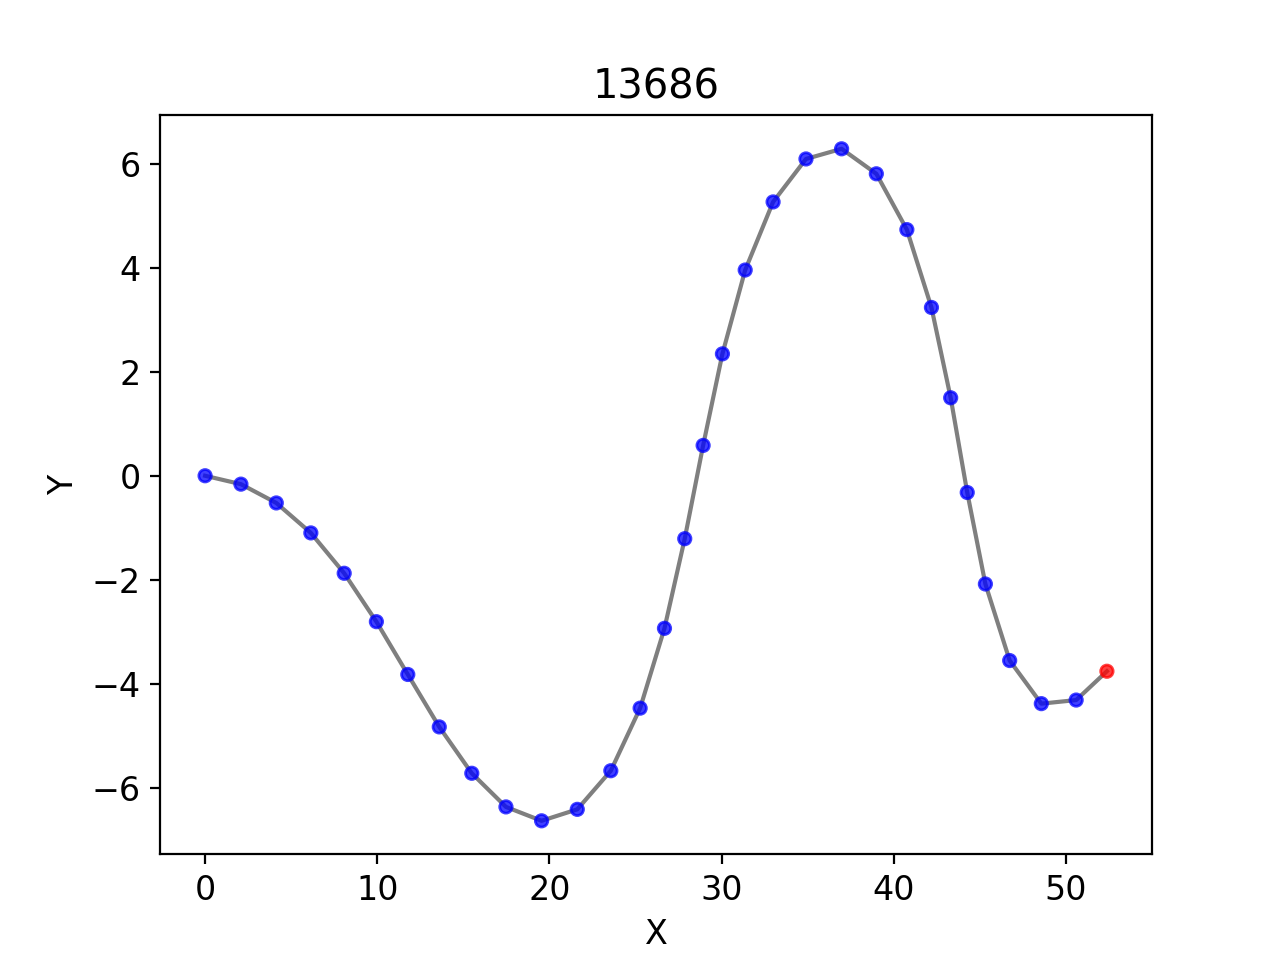

<IPython.core.display.Javascript object>


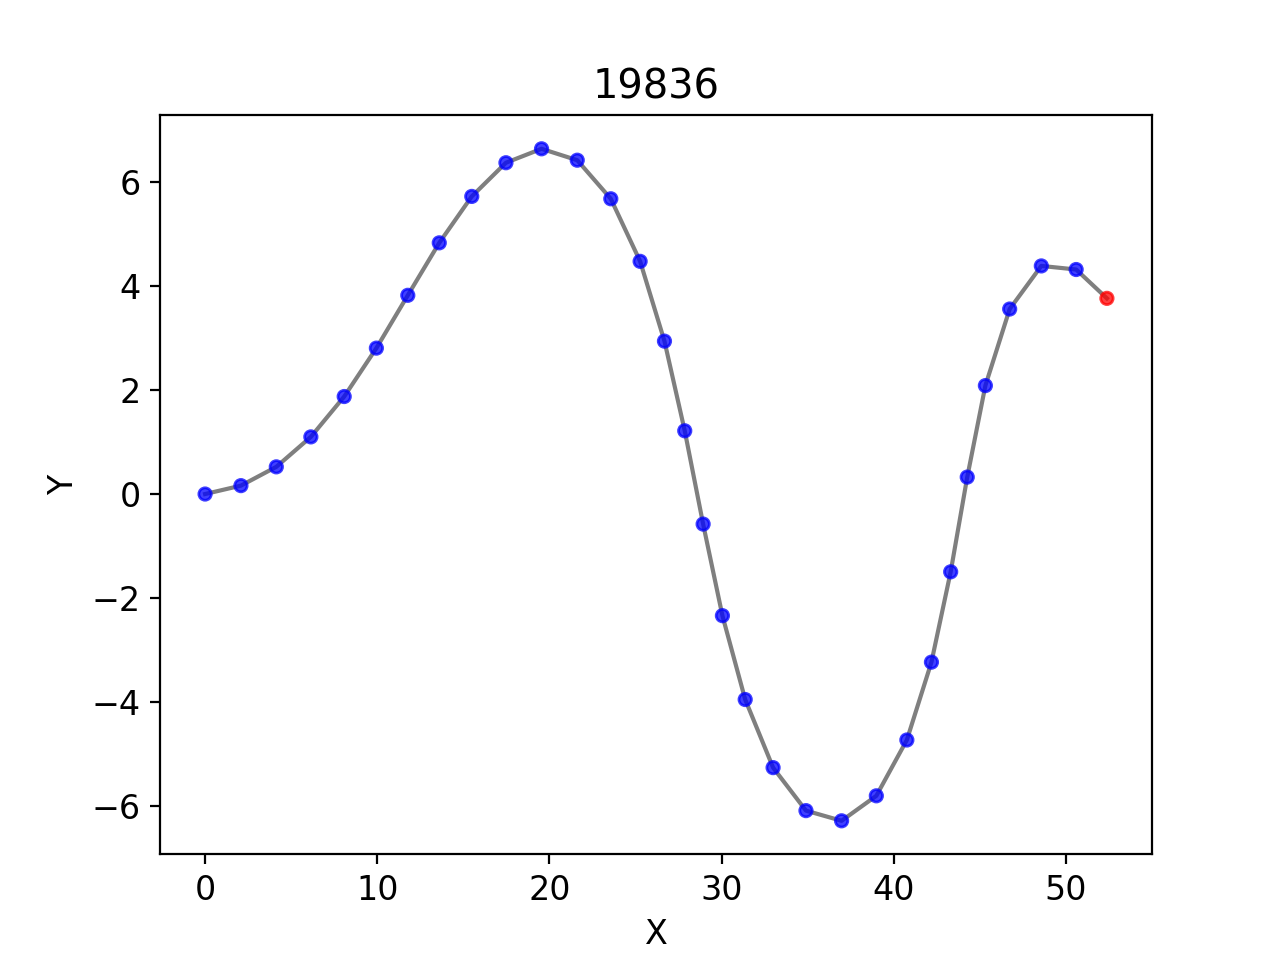

<IPython.core.display.Javascript object>


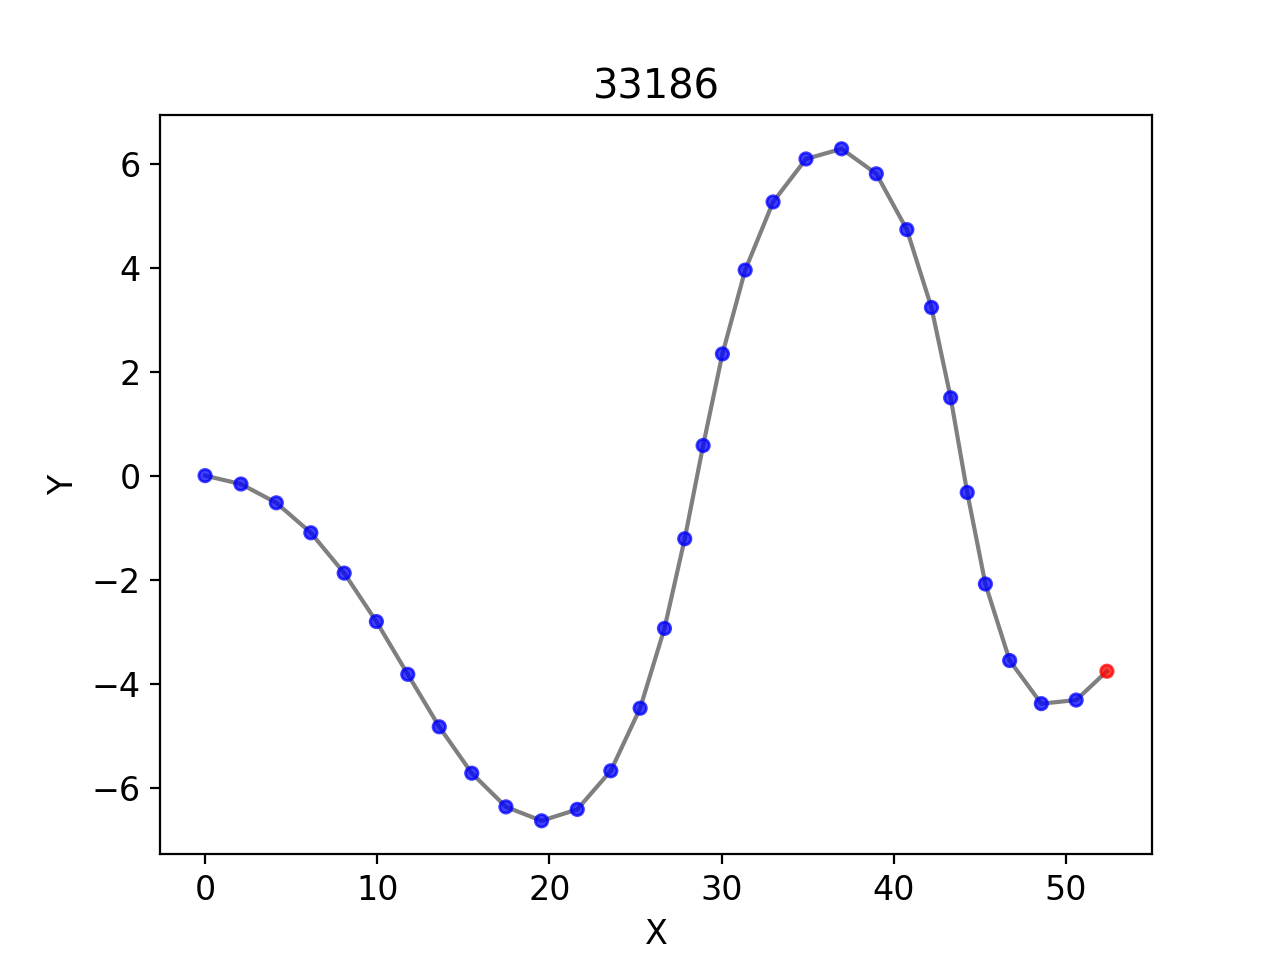

<IPython.core.display.Javascript object>


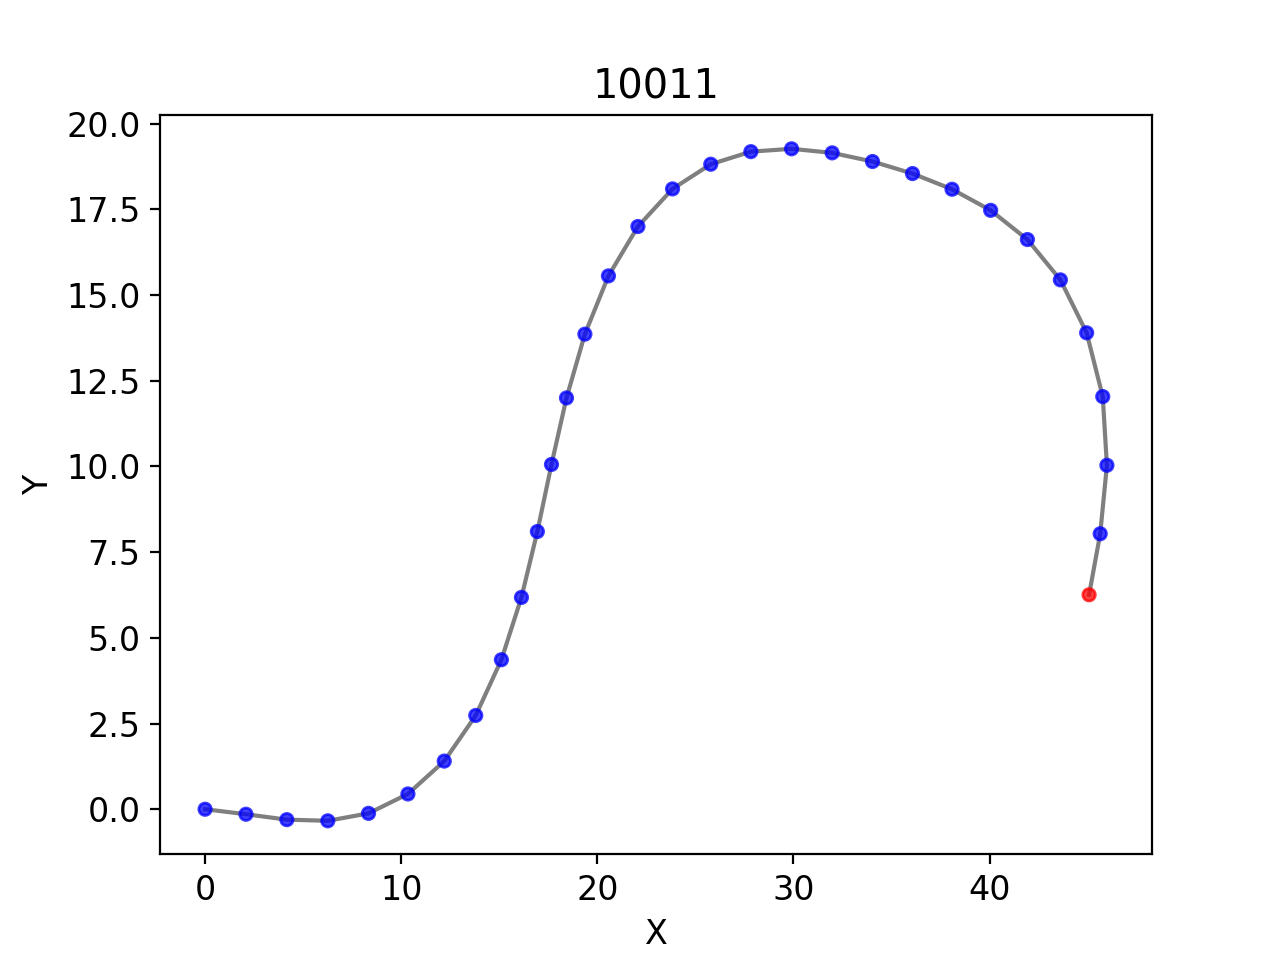

<IPython.core.display.Javascript object>


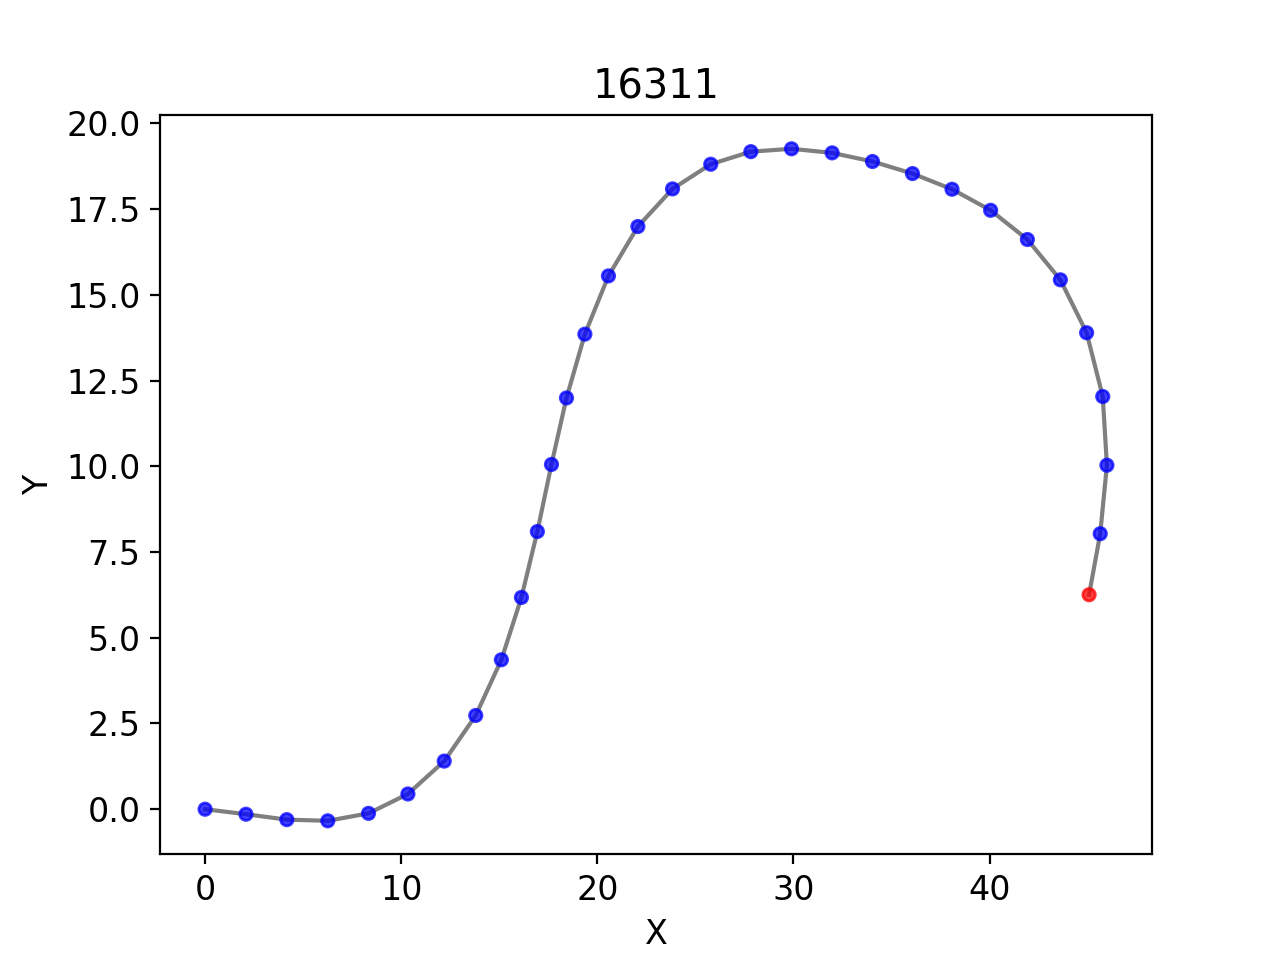

<IPython.core.display.Javascript object>


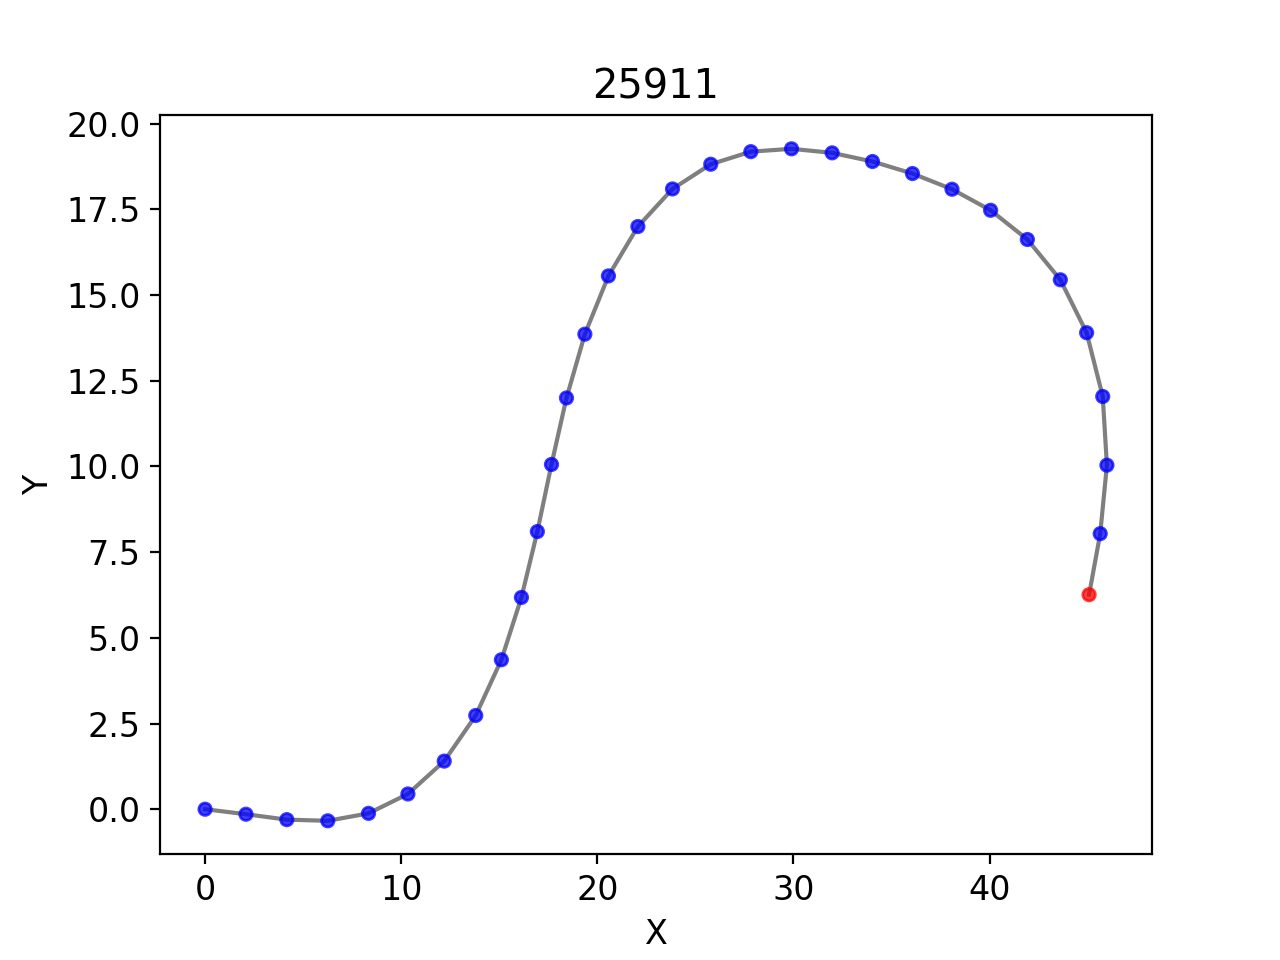

<IPython.core.display.Javascript object>


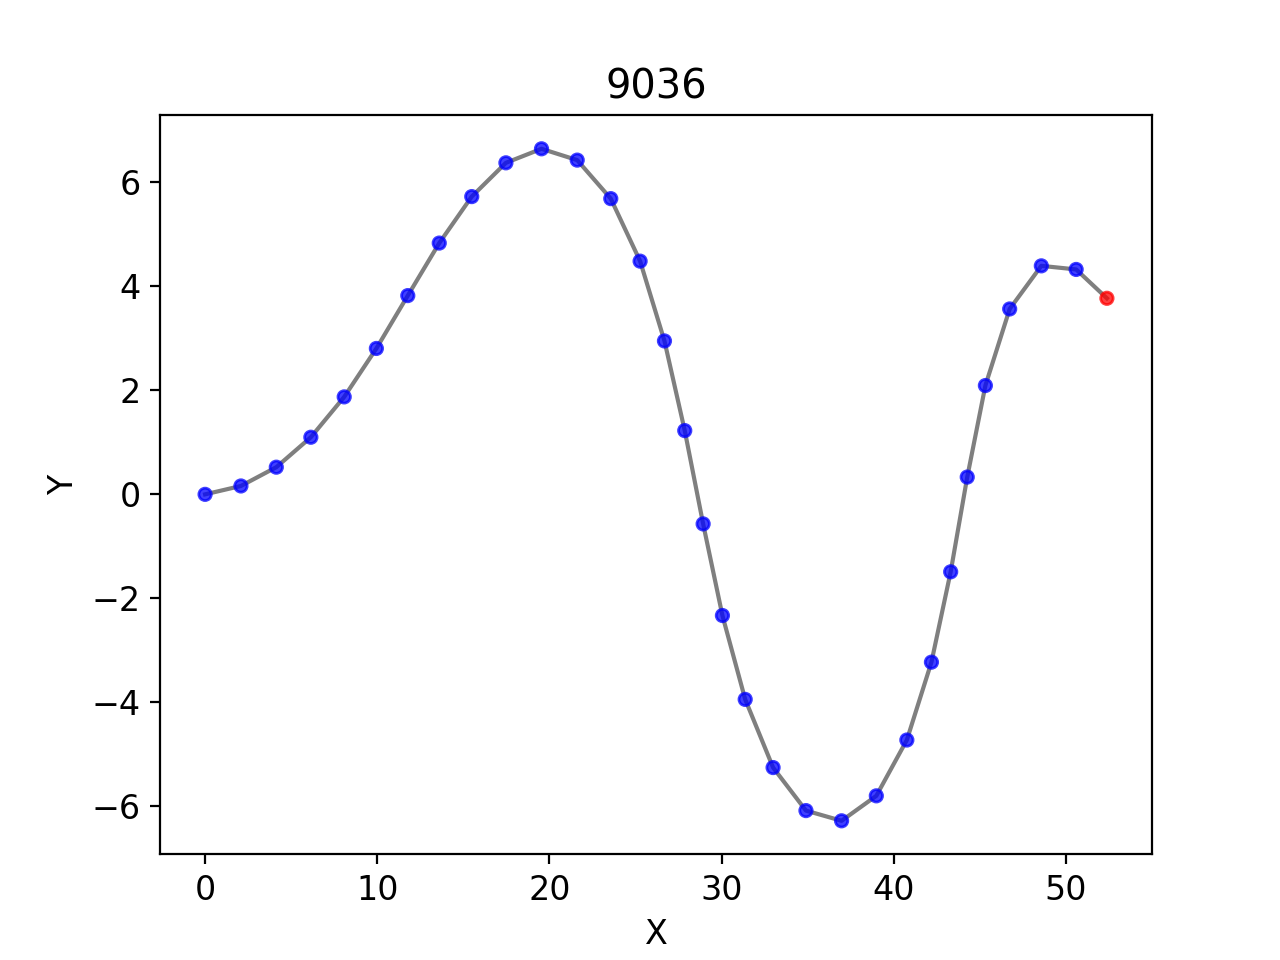

In [39]:



if not(os.path.exists(ic_analysis_folder)):
       os.makedirs(ic_analysis_folder)


# Use a fixed seed to generate repeatable random numbers

np.random.seed(0)

filament_init_shape = np.zeros(fil.Np*fil.dim, dtype = np.double)


for ii in range(N_IC_time):
    
    for jj in range(N_IC_phase):
        
        time_index = ic_mesh[ii, jj]
        
        phase = phase_array[time_index]
        
        ic_folder = os.path.join(ic_analysis_folder, 'IC_{}'.format(time_index))
       
        if(not os.path.exists(ic_folder)):
           os.makedirs(ic_folder)
           
        
        filament_shape = fil.R[time_index,:]
        
        plt.figure()
        fil.plotFilament(r = filament_shape)
        plt.title(time_index)
        
        for kk in range(N_IC_nearby):
            # Add noise along X direction
            filament_init_shape[1:fil.Np] = filament_shape[1:fil.Np]+ np.random.normal(0, delta_IC, fil.Np-1)
            # Add noise along Y direction
            filament_init_shape[fil.Np+1:2*fil.Np] = filament_shape[fil.Np+1:2*fil.Np]+ np.random.normal(0, delta_IC, fil.Np-1)
            
            save_file = 'filament_ic_{0:03d}'.format(kk)
            
            
            # Save the resulting filament shapes to disk
            with h5py.File(os.path.join(ic_folder, save_file), "w") as f:

                dset = f.create_group("simulation data")
                dset.create_dataset("Initial Position", data = filament_init_shape)
                dset.attrs['Time index'] = time_index
                # Also save the phase value of the simulation
                dset.attrs['Phase'] = phase
            



# Run Simulations with the Closely Spaced ICs as starting points


In [8]:
# Load and build a dictionary containing all the ICs

folders = ['IC_25911']

first_index = 0
second_index = fil.Np

# Create a dictionary to store all IC we want to simulate

ic_list = {}

ic_counter = 0

for folder in folders:
    
    ic_files = os.listdir(os.path.join(ic_analysis_folder, folder))
    
    for file in ic_files:
        
        with h5py.File(os.path.join(ic_analysis_folder, folder, file), "r") as f:
            if('simulation data' in f.keys()): # Load the simulation data
                dset = f['simulation data']
                r = np.array(dset["Initial Position"][:])
                time_point = int(dset.attrs["Time index"])
                phase = dset.attrs['Phase']
                
#         plt.scatter(r[first_index:first_index+fil.Np], r[second_index:second_index+fil.Np], 20, c = fil.particle_colors, alpha = 0.75, zorder = 20)

#         plt.plot(r[first_index:first_index+fil.Np], r[second_index:second_index+fil.Np], color = 'k', alpha = 0.5, zorder = 10)
    
        ic_list[ic_counter] = {'path':os.path.join(ic_analysis_folder, folder), 'ic':file, 'filament shape':r, 'phase':phase}
        
      
        ic_counter+=1
                


In [9]:
len(ic_list)

10

# Run a parallel simulation using all the ICs that we have generated

In [10]:
# No:of activity cycles we want to simulate
n_activity_cycles = 100
# Total simulation time
Tf = fil.activity_timescale*n_activity_cycles

# activity_timescale = 1000

# Total simulation time
# No:of time points saved
time_step_save = 20
Npts = int(Tf/time_step_save)

bc = {0:'clamped', -1:'free'}

dim = fil.dim
Np = fil.Np
radius = fil.radius
b0 = fil.b0
k = fil.k
S0 = fil.S0
D0 = fil.D0
activity_timescale = fil.activity_timescale

def run_ic_simulation(ic, path, filament_shape, phase):
    
    # Simulate each IC
    new_fil = activeFilament(dim = dim, Np = Np, radius = radius, b0 = b0, k = k, S0 = S0, D0 = D0, bc = bc)

    new_fil.simulate(Tf, Npts, n_cycles = n_activity_cycles, save = True, overwrite = False, path = path, sim_type = 'point', 
    init_condition = {'filament':filament_shape}, 
    activity={'type':'square-wave','activity_timescale':activity_timescale, 'duty_cycle':0.5, 'start phase':phase},
                note = ic, create_subdirs=False)


In [11]:
from joblib import Parallel, delayed
import multiprocessing

num_cores = multiprocessing.cpu_count()

print(num_cores)

num_cores = 12

results = Parallel(n_jobs = num_cores,  verbose=10)(delayed(run_ic_simulation)(ic_list[ic_index]['ic'], ic_list[ic_index]['path'], ic_list[ic_index]['filament shape'], ic_list[ic_index]['phase']) for ic_index in tqdm(ic_list.keys()))


100%|██████████| 10/10 [00:00<00:00, 1867.12it/s]

16



[Parallel(n_jobs=12)]: Done   3 out of  10 | elapsed:  4.8min remaining: 11.3min
[Parallel(n_jobs=12)]: Done   5 out of  10 | elapsed:  5.7min remaining:  5.7min
[Parallel(n_jobs=12)]: Done   7 out of  10 | elapsed:  6.0min remaining:  2.6min
[Parallel(n_jobs=12)]: Done  10 out of  10 | elapsed:  6.7min finished


# Analyze the results of the IC simulations
- calculate pair-wise distance between different closely spaced ICs.
- Average this distance metric over many different time and phase points.
- Plot and store this average distance metric vs time
- Try to fit an exponential to this curve and measure the rate of growth.

In [12]:
import itertools
import pandas as pd



# Aperiodic
# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5256410256410255_activityTime_750_simType_point/IC_analysis/IC_16906/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5256410256410255_activityTime_750_simType_point'


# 2 Period
# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point/IC_analysis/IC_30140/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point'

# 4 Period
# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_30925/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point'
# 6 period
# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5897435897435896_activityTime_750_simType_point/IC_analysis/IC_33155/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5897435897435896_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5897435897435896_activityTime_750_simType_point/IC_analysis/IC_13819/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5897435897435896_activityTime_750_simType_point'
# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5897435897435896_activityTime_750_simType_point/IC_analysis/IC_33244/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5897435897435896_activityTime_750_simType_point'
# 10 period
# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.3974358974358974_activityTime_750_simType_point/IC_analysis/IC_32091/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.3974358974358974_activityTime_750_simType_point'

# Constant compressive activity
# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ConstantCompressiveActivity_sweep/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point/IC_analysis/IC_18251/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ConstantCompressiveActivity_sweep/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point/IC_analysis/IC_9813/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5256410256410255_activityTime_750_simType_point/IC_analysis/IC_16767/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5256410256410255_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point/IC_analysis/IC_34368/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.205128205128205_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.3974358974358974_activityTime_750_simType_point/IC_analysis/IC_33600/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.3974358974358974_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.6794871794871793_activityTime_750_simType_point/IC_analysis/IC_19683/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.6794871794871793_activityTime_750_simType_point'


# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5897435897435896_activityTime_750_simType_point/IC_analysis/IC_36208/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.5897435897435896_activityTime_750_simType_point'

# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.9743589743589742_activityTime_750_simType_point/IC_analysis/IC_30652/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.9743589743589742_activityTime_750_simType_point'


# ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_33186/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point'

ic_folder = '/home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point'
if (not os.path.exists(os.path.join(ic_folder,'Pairwise_distance.csv'))):

    ic_sim_files = [file for file in os.listdir(ic_folder) if file.endswith('.hdf5')]

    print(ic_sim_files)

    # Load the first file to extract parameters
    fil = analysis.analysisTools(file = os.path.join(ic_folder, ic_sim_files[0]))

    # Create an array to store the pair-wise distance among all IC
    N_IC = len(ic_sim_files)

    # Unique pairs
    N_pairs = int(N_IC*(N_IC - 1)/2)

    N_time = len(fil.Time)


    pairwise_distance_array = np.empty((N_pairs, N_time))

    fil_pairs = list(itertools.combinations(ic_sim_files, 2))

    pairwise_distance_df = pd.DataFrame({})

    for ii in tqdm(range(len(fil_pairs))):

        fil_1 = analysis.analysisTools(file = os.path.join(ic_folder, fil_pairs[ii][0]))
        fil_2 = analysis.analysisTools(file = os.path.join(ic_folder, fil_pairs[ii][1]))

        assert(np.shape(fil_1.R)==np.shape(fil_2.R))
        for jj in range(N_time):
            r1 = fil_1.R[jj,:]
            r2 = fil_2.R[jj,:]

            pairwise_distance_array[ii, jj] = fil_1.euclidean_distance(r1, r2)

        pairwise_distance_df = pairwise_distance_df.append(pd.DataFrame({'Time':fil_1.Time, 
                                                                         'IC 1':np.repeat(fil_pairs[ii][0], N_time), 
                                                                         'IC 2':np.repeat(fil_pairs[ii][1], N_time),
                                                                         'Distance':pairwise_distance_array[ii, :]}))
    # Save the pairwise data to file
    pairwise_distance_df.to_csv(os.path.join(ic_folder, 'Pairwise_distance.csv'))
else:
    pairwise_distance_df = pd.read_csv(os.path.join(ic_folder,'Pairwise_distance.csv'))
        
        
# for file in ic_sim_files:
    
    # Load the filament simulation data
    
    
    # Store the filament shapes in an array

  0%|          | 0/45 [00:00<?, ?it/s]

['SimResults_00_filament_ic_008.hdf5', 'SimResults_00_filament_ic_009.hdf5', 'SimResults_00_filament_ic_002.hdf5', 'SimResults_00_filament_ic_001.hdf5', 'SimResults_00_filament_ic_000.hdf5', 'SimResults_00_filament_ic_003.hdf5', 'SimResults_00_filament_ic_007.hdf5', 'SimResults_00_filament_ic_004.hdf5', 'SimResults_00_filament_ic_006.hdf5', 'SimResults_00_filament_ic_005.hdf5']
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_008.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity pr

  2%|▏         | 1/45 [00:00<00:27,  1.59it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_008.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

  4%|▍         | 2/45 [00:01<00:26,  1.59it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_008.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

  7%|▋         | 3/45 [00:01<00:28,  1.49it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_008.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

  9%|▉         | 4/45 [00:02<00:26,  1.54it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_008.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 11%|█         | 5/45 [00:03<00:25,  1.58it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_008.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 13%|█▎        | 6/45 [00:03<00:25,  1.56it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_008.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 16%|█▌        | 7/45 [00:04<00:23,  1.59it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_008.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 18%|█▊        | 8/45 [00:05<00:22,  1.62it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_008.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 20%|██        | 9/45 [00:05<00:22,  1.57it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_009.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 22%|██▏       | 10/45 [00:06<00:22,  1.59it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_009.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 24%|██▍       | 11/45 [00:06<00:21,  1.58it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_009.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 27%|██▋       | 12/45 [00:07<00:21,  1.57it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_009.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 29%|██▉       | 13/45 [00:08<00:20,  1.58it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_009.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 31%|███       | 14/45 [00:08<00:19,  1.57it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_009.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 33%|███▎      | 15/45 [00:09<00:19,  1.55it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_009.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 36%|███▌      | 16/45 [00:10<00:18,  1.54it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_009.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 38%|███▊      | 17/45 [00:10<00:18,  1.52it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_002.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 40%|████      | 18/45 [00:11<00:17,  1.51it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_002.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 42%|████▏     | 19/45 [00:12<00:16,  1.53it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_002.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 44%|████▍     | 20/45 [00:12<00:16,  1.55it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_002.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 47%|████▋     | 21/45 [00:13<00:15,  1.59it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_002.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 49%|████▉     | 22/45 [00:14<00:14,  1.61it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_002.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 51%|█████     | 23/45 [00:14<00:13,  1.62it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_002.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 53%|█████▎    | 24/45 [00:15<00:13,  1.60it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_001.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 56%|█████▌    | 25/45 [00:15<00:12,  1.58it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_001.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 58%|█████▊    | 26/45 [00:16<00:11,  1.59it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_001.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 60%|██████    | 27/45 [00:17<00:11,  1.59it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_001.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 62%|██████▏   | 28/45 [00:17<00:10,  1.57it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_001.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 64%|██████▍   | 29/45 [00:18<00:10,  1.57it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_001.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 67%|██████▋   | 30/45 [00:19<00:09,  1.54it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_000.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 69%|██████▉   | 31/45 [00:19<00:09,  1.53it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_000.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 71%|███████   | 32/45 [00:20<00:08,  1.54it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_000.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 73%|███████▎  | 33/45 [00:21<00:07,  1.55it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_000.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 76%|███████▌  | 34/45 [00:21<00:07,  1.55it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_000.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 78%|███████▊  | 35/45 [00:22<00:06,  1.54it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_003.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 80%|████████  | 36/45 [00:23<00:05,  1.53it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_003.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 82%|████████▏ | 37/45 [00:23<00:05,  1.55it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_003.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 84%|████████▍ | 38/45 [00:24<00:04,  1.57it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_003.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 87%|████████▋ | 39/45 [00:24<00:03,  1.54it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_007.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 89%|████████▉ | 40/45 [00:25<00:03,  1.54it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_007.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 91%|█████████ | 41/45 [00:26<00:02,  1.53it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_007.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 93%|█████████▎| 42/45 [00:26<00:01,  1.53it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_004.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 96%|█████████▌| 43/45 [00:27<00:01,  1.54it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_004.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

 98%|█████████▊| 44/45 [00:28<00:00,  1.56it/s]

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point
Data file SimResults_00_filament_ic_006.hdf5
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 19.99466808850973
No:of particles : 32
No:of time points : 3751
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ActivityStrength_sweep/2021-08-20/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point/IC_analysis/IC_25911/SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3

100%|██████████| 45/45 [00:28<00:00,  1.56it/s]


In [44]:
## Plots
publication_figures = '/home/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures'


temp, file_name = os.path.split(fil.rootFolder)
    
print(file_name)

SimResults_Np_32_Shape_line_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.3589743589743586_activityTime_750_simType_point


<IPython.core.display.Javascript object>


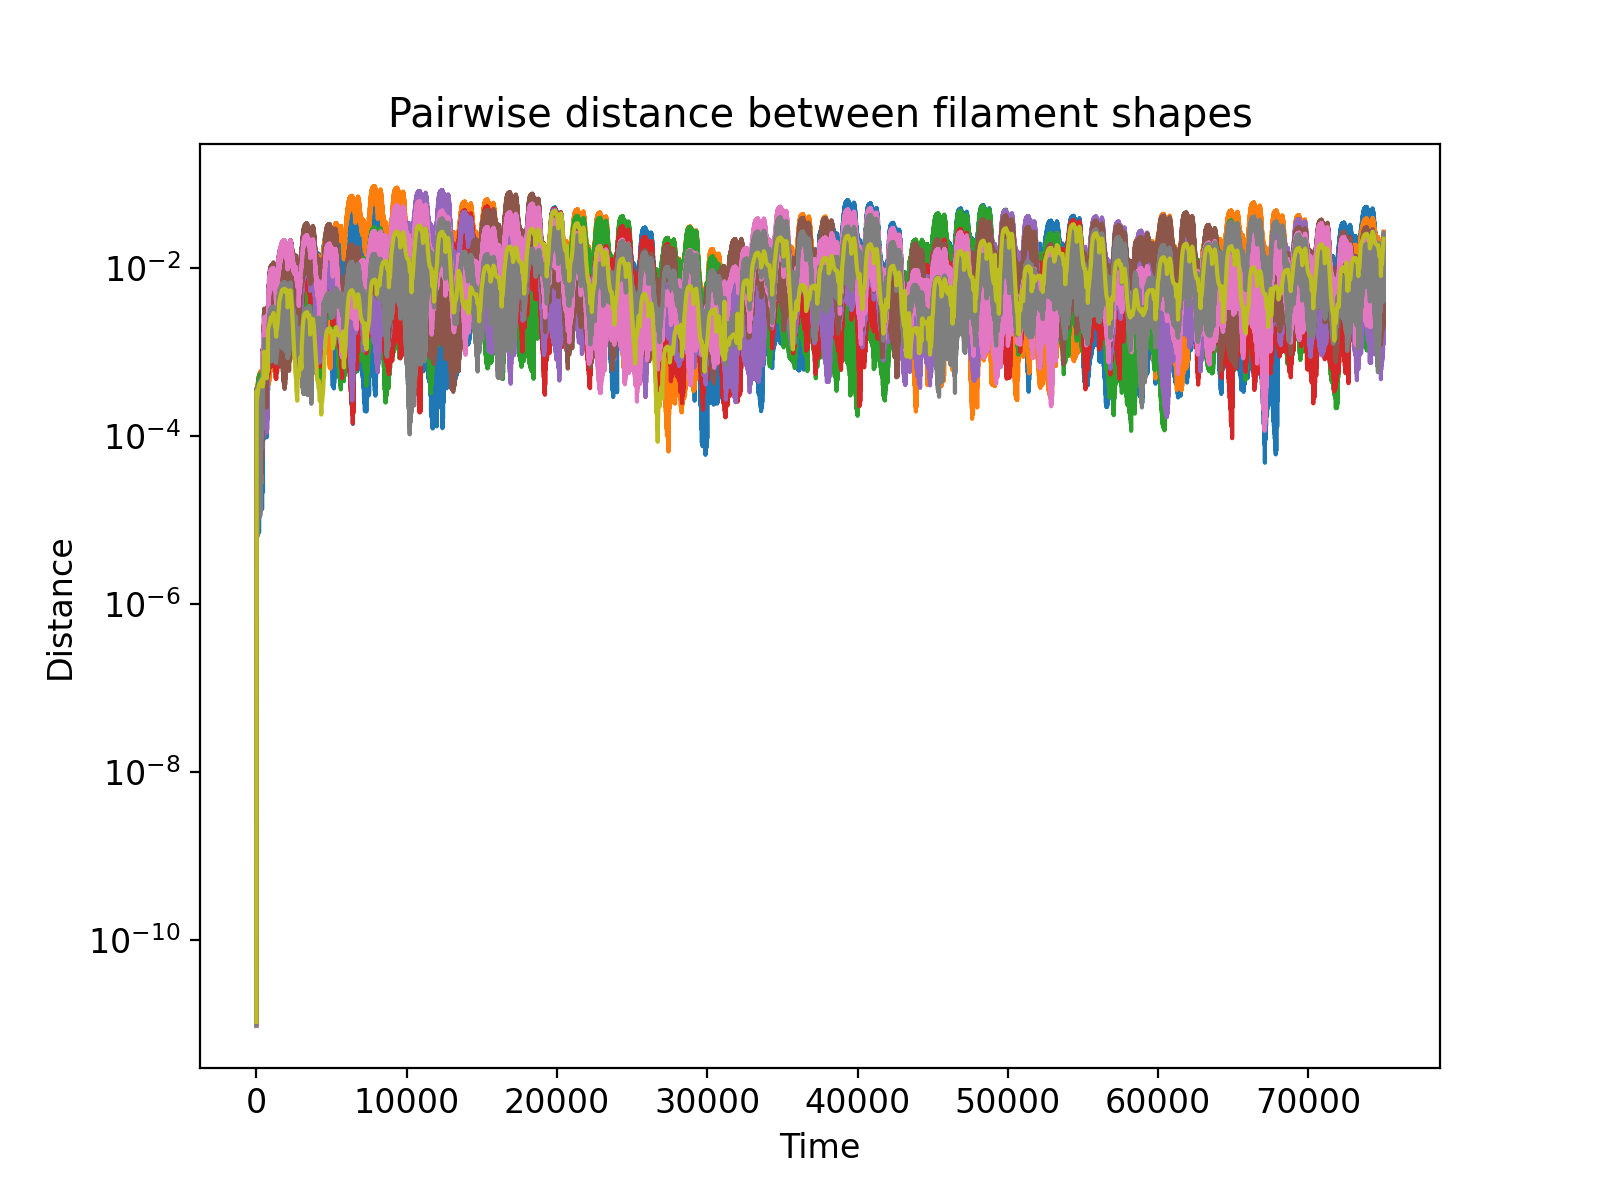

In [13]:
# Plot the pair-wise distance vs time (for all IC pairs)
import seaborn as sns

plt.figure(figsize = (8,6))
plt.title('Pairwise distance between filament shapes')
sns.lineplot(x='Time', y = 'Distance', data = pairwise_distance_df, hue = 'IC 1', estimator = None, legend = False)
plt.yscale('log')


# plt.savefig(os.path.join(publication_figures, file_name + 'pairwise_distance'+'.png'), dpi = 300, bbox_inches = 'tight')
# plt.savefig(os.path.join(publication_figures, file_name + 'pairwise_distance'+'.svg'), dpi = 300, bbox_inches = 'tight')
plt.show()

<IPython.core.display.Javascript object>


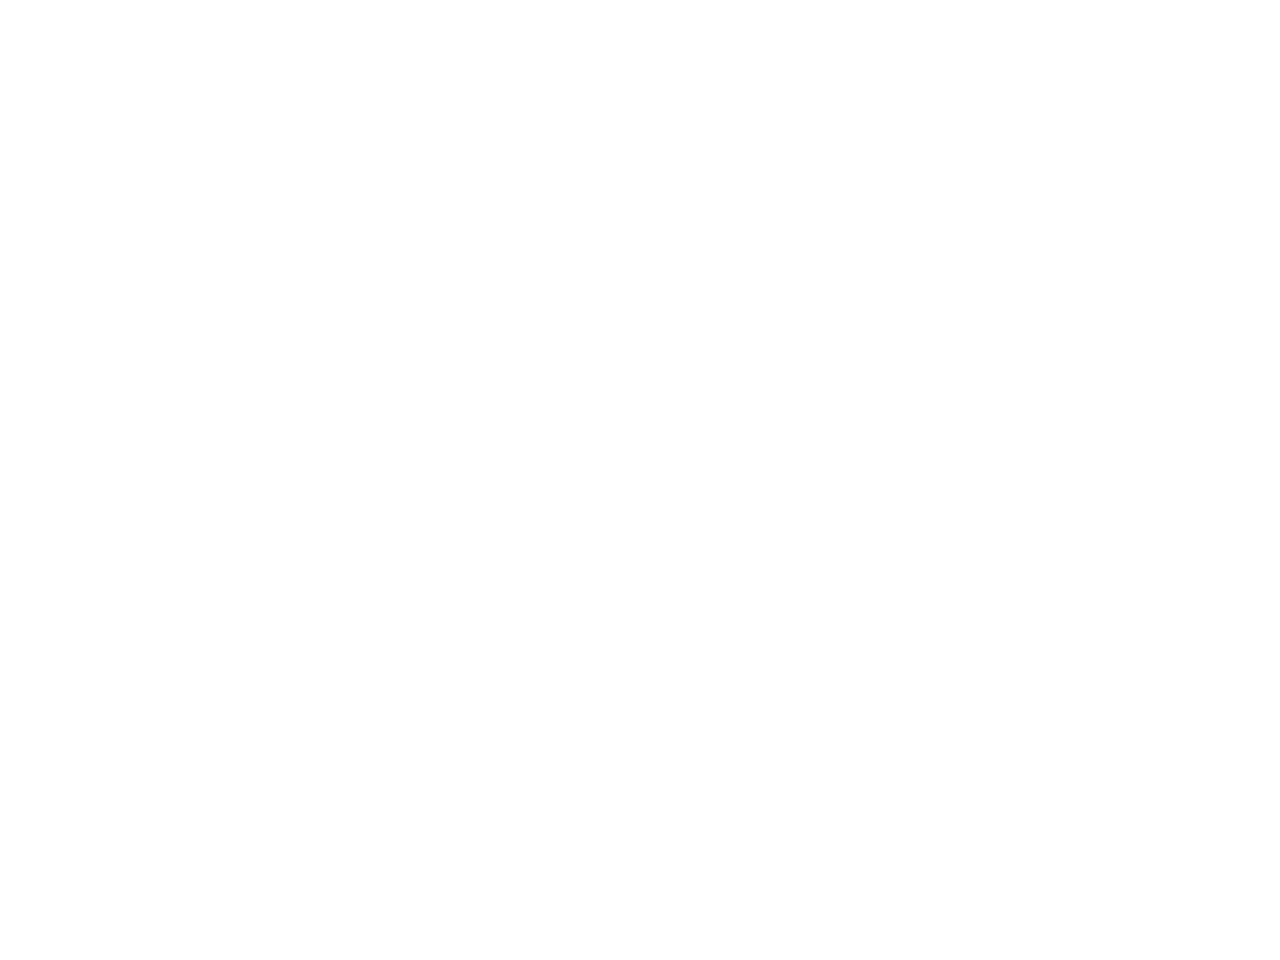

KeyboardInterrupt: 

In [177]:
plt.figure()

sns.lineplot(x='Time', y = 'Distance', data = pairwise_distance_df, hue = 'IC 1', ci = 95)
plt.yscale('log')
plt.show()